# Variations on Cell Proximity Effect Analysis

This notebook contains all experiments relating to computing and characterizing cell proximity effects using a few variations on the standard approach (i.e. alternative definitions of the "Far" group, area-restricted proximity effect analysis, using different non-spatial aging clocks). It uses the spatial aging clocks to compute age acceleration for the analysis.

**Associated manuscript figures/tables:**
- Extended Data Figures: 9e,f,i,j

**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

from ageaccel_proximity import *

In [2]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltypes_full = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']

In [3]:
# Distance Cutoff Parameters -- see 5A_regional_proximity_distance_cutoffs.ipynb

cutoff = {'CC/ACO': 24.887910095931538, 'CTX_L1/MEN': 25.91425280674148, 'CTX_L2/3': 24.04649324744985, 'CTX_L4/5/6': 27.243990001598508, 'STR_CP/ACB': 21.6499141249257, 'STR_LS/NDB': 20.355186196238336, 'VEN': 17.863153902391776}

# Cell proximity age acceleration analysis

## Controls: Random matching and Transcript Count matching

### Random matching of Far cell outside radius

In [ ]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,
                                                comparison="random")
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedRANDOM_cohensd.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_RANDOM.pdf",
            bbox_inches='tight')
plt.show()

### Matching of Far cell by total transcript count similarity

In [ ]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,
                                                comparison="transcript_count")
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedTRANSCRIPT_cohensd.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_TRANSCRIPT.pdf",
            bbox_inches='tight')
plt.show()

## Control: Exclude bordering cells (to remove any mis-segmentation / transcript mis-allocation effects)

/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_ind(adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/local/scratch/edsun/slrmtmp.42905280/ipykernel_89735/226969130.py:48: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "A

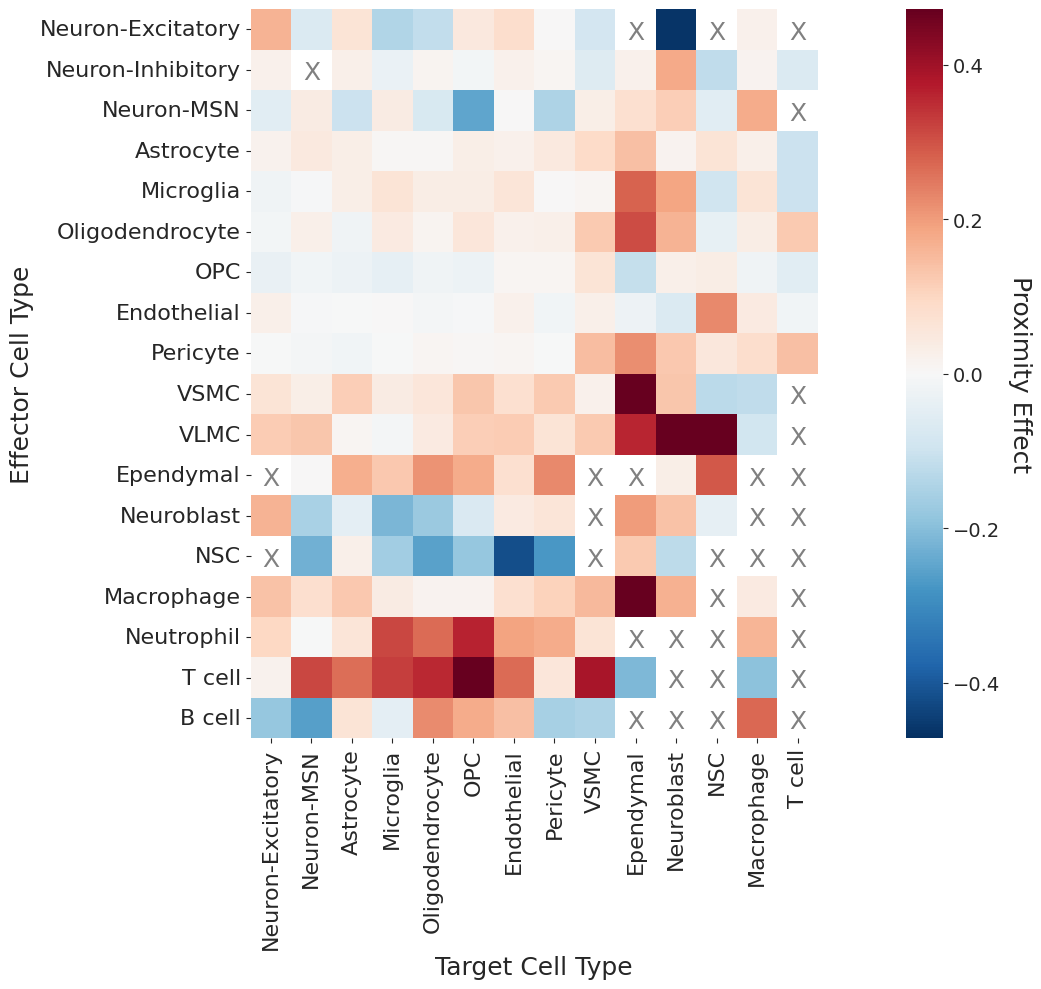

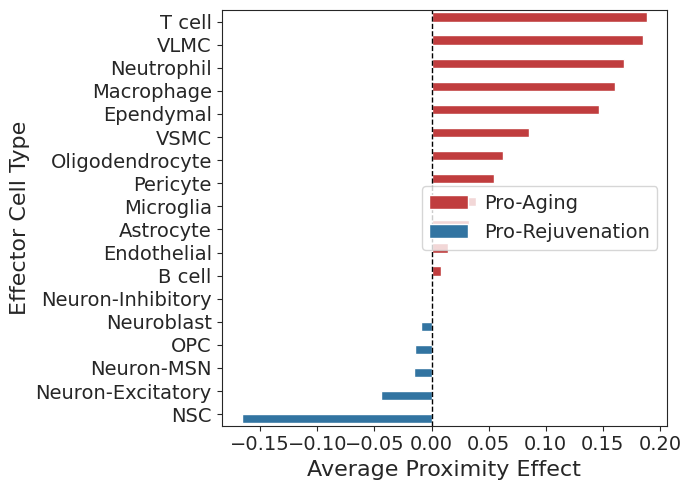

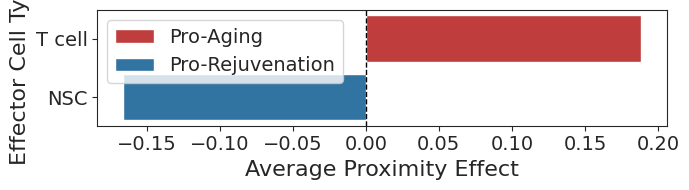

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 2

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,
                                                ring_width=15)
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_spatialsmooth_regionmatchedfarthest_cohensd_2RING15.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_2RING15.pdf",
            bbox_inches='tight')
plt.show()



# generate vertical bar plot
plt.figure(figsize=(7,2))

g = sns.barplot(
    x=average_effects[pd.Series(celltypes).isin(["T cell", "NSC"])],
    y=celltypes[pd.Series(celltypes).isin(["T cell", "NSC"])],
    hue=colors[pd.Series(celltypes).isin(["T cell", "NSC"])],
    palette=palette, dodge=False
)

plt.margins(y=0.05)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_RING15_TNonly.pdf",
            bbox_inches='tight')
plt.show()

## Control: Non-smoothing clock predictions with border cell exclusion

### Single-cell aging clocks (pseudobulked training)

/local/scratch/edsun/slrmtmp.42905202/ipykernel_12284/3557081248.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")


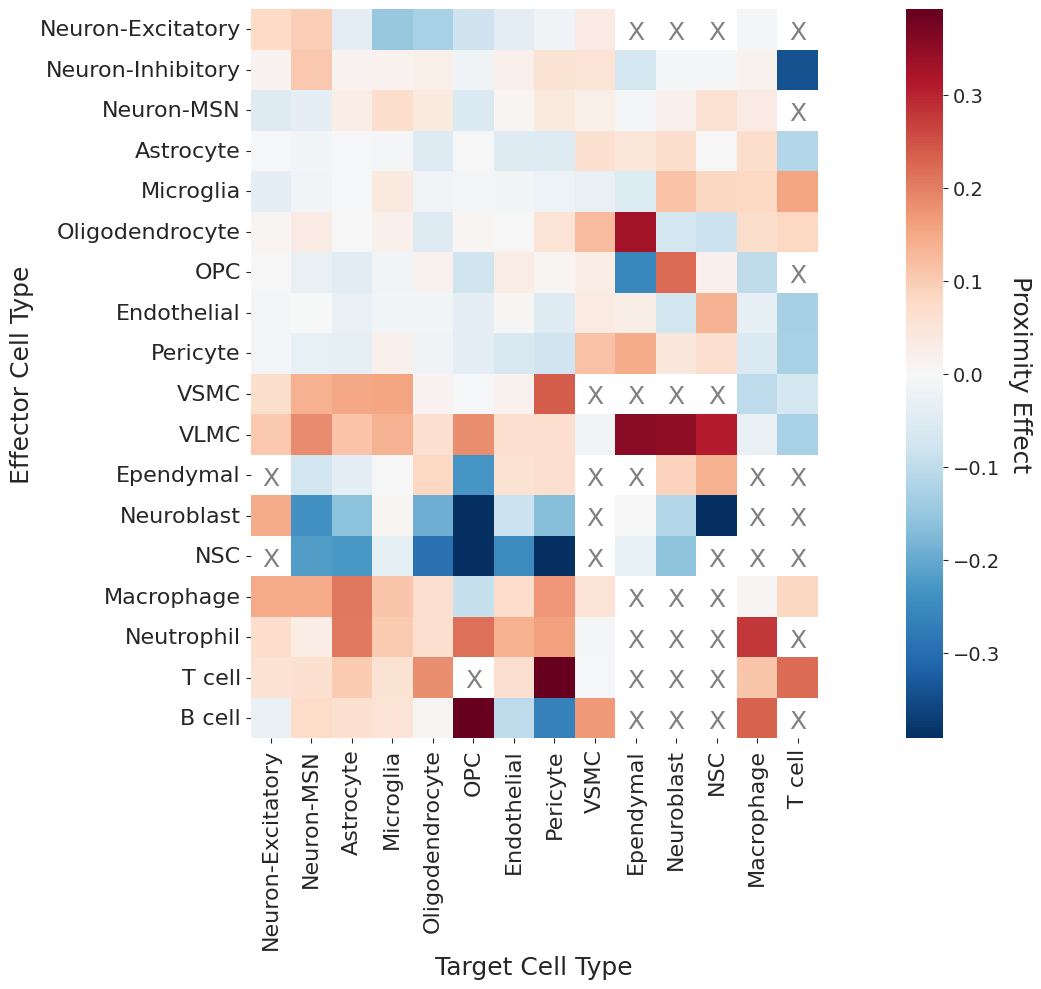

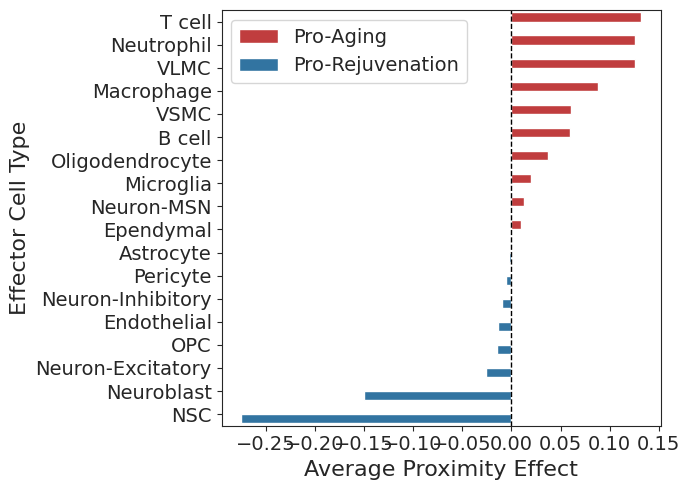

In [8]:
### Original setup with single-cell clocks

adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_B1k_singlecellpred.h5ad")
#adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsinglecell_alpha08_nneigh20.h5ad")


# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 1

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,)
                                                #comparison="transcript_count")
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_PBsinglecell_regionmatchedfarthest_cohensd.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_PBsinglecell.pdf",
            bbox_inches='tight')
plt.show()

### SpatialSmooth off at test-time only

/oak/stanford/scg/lab_abrunet1/Eric/MERFISH/ageaccel_proximity.py:199: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_ind(adata.obs['normalized_age_acceleration'].copy()[near_ages=="Near"],
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/local/scratch/edsun/slrmtmp.42905280/ipykernel_89735/1071844935.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "

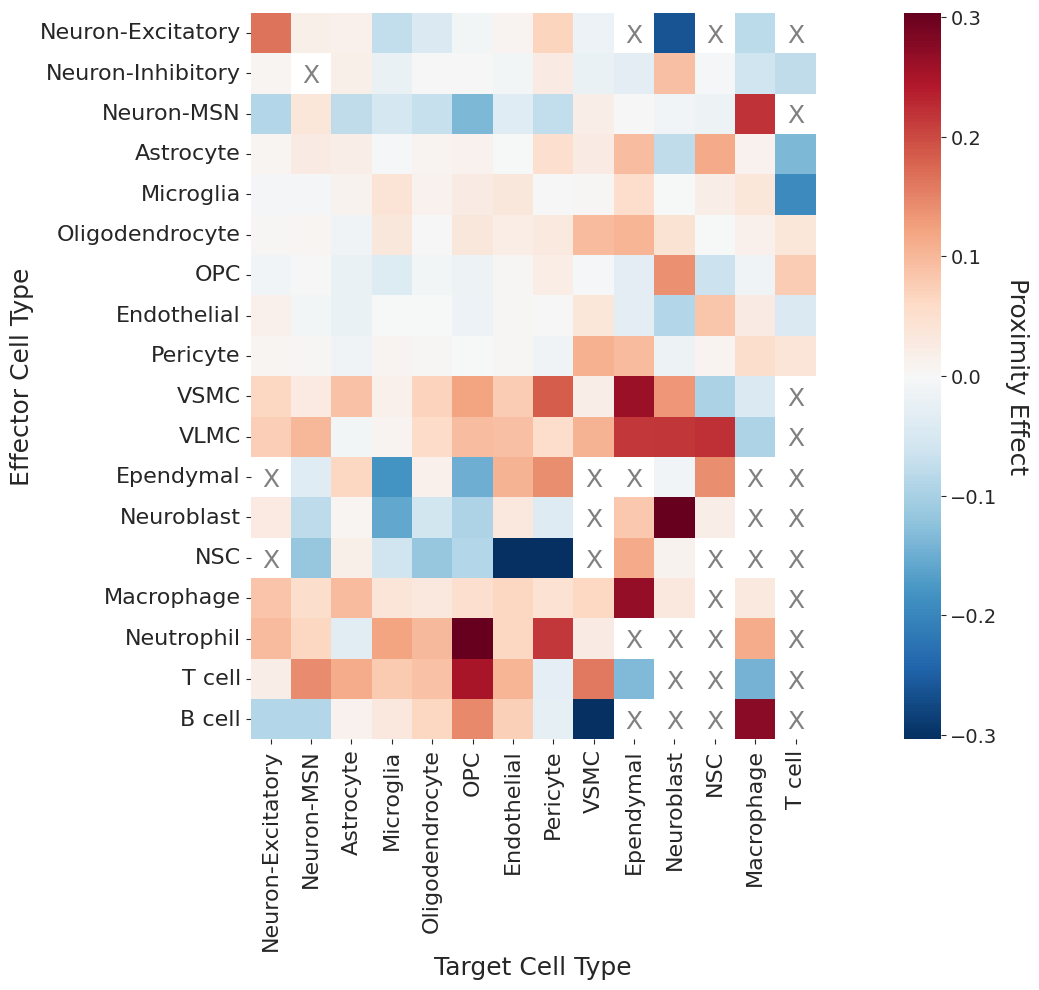

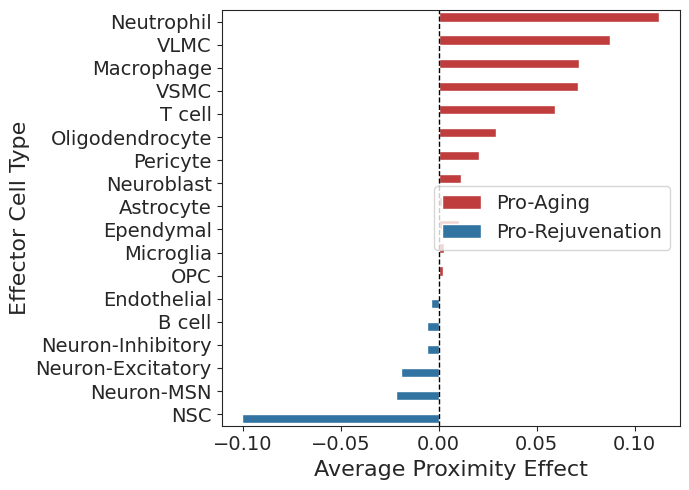

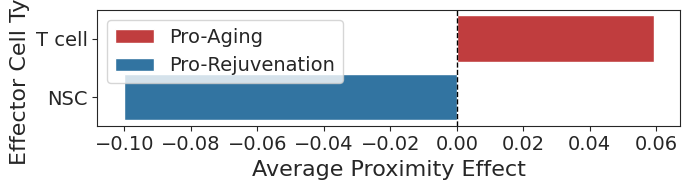

In [6]:
### Border exclusion with single-cell clocks

#adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_B1k_singlecellpred.h5ad")
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsinglecell_alpha08_nneigh20.h5ad")


# compute age acceleration
get_age_acceleration (adata)

# Compute nearest to cell type distances
nearest_distance_to_celltype(adata,
                             celltype_list=pd.unique(adata.obs.celltype).sort_values(),
                             sub_id="mouse_id")

# Compute proximity stats

cutoff_multiplier = 2

celltypes = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
###########################
comb_df = pd.DataFrame([])

for celltype in celltypes:
    
    for ct in pd.unique(adata.obs.celltype).sort_values():
        
        sub_adata = adata[adata.obs["celltype"]==ct]
        
        # get paired proximity sets
        near_ages = get_paired_proximity_labels(sub_adata, cutoff, celltype, cutoff_multiplier=cutoff_multiplier,
                                                ring_width=15)#, comparison="random")
        
        # run test
        df = get_stats_df(sub_adata, near_ages, cutoff_multiplier, celltype, ct, adata)
        
        comb_df = pd.concat((comb_df, df))
        

        
######################################

# Heatmap visualization of all proximity effects

comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()
comb_df_sub["Near Cell"] = comb_df_sub["Near Cell"].astype('category').cat.reorder_categories([x for x in celltypes_full if x in comb_df_sub['Near Cell'].values])
comb_df_sub["AgeAccel Cell"] = comb_df_sub["AgeAccel Cell"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in comb_df_sub['AgeAccel Cell'].values])

pivot_df = comb_df_sub.pivot("Near Cell", "AgeAccel Cell", "Aging Effect")

fig, ax = plt.subplots(figsize=(18,10))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.5"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap="RdBu_r",
            vmin=-np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98),
            vmax=np.nanquantile(np.abs(comb_df_sub["Aging Effect"]), 0.98))

ax.collections[1].colorbar.set_label('Proximity Effect',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.ylabel("Effector Cell Type", fontsize=18)
plt.xlabel("Target Cell Type", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_ttest_heatmap_ALL_SSsinglecell_regionmatchedfarthest_cohensd_2RING15.pdf",
          bbox_inches='tight')
plt.show()


##########################################

# subset to only restricted cells among target cell types
comb_df_sub = comb_df[comb_df["AgeAccel Cell"].isin(restricted_celltype_subset)].copy()

# compute average proximity effects for each effector cell and then rank order
celltypes = []
average_effects = []
colors = []

for ct in np.unique(comb_df_sub["Near Cell"]):
    average_effect = np.nanmean(comb_df_sub[comb_df_sub["Near Cell"]==ct]["Aging Effect"])
    if average_effect > 0:
        color = 'Pro-Aging'
    else:
        color = 'Pro-Rejuvenation'
    
    celltypes.append(ct)
    average_effects.append(average_effect)
    colors.append(color)

sort_idxs = np.argsort(average_effects)[::-1]
celltypes = np.array(celltypes)[sort_idxs]
colors = np.array(colors)[sort_idxs]
average_effects = np.array(average_effects)[sort_idxs]


palette = {"Pro-Aging":"tab:red",
           "Pro-Rejuvenation":"tab:blue"}

# generate vertical bar plot
plt.figure(figsize=(7,5))

g = sns.barplot(
    x=average_effects,
    y=celltypes,
    hue=colors,
    palette=palette,
)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_SSsinglecell_2RING15.pdf",
            bbox_inches='tight')
plt.show()



### T cell and NSC only

# generate vertical bar plot
plt.figure(figsize=(7,2))

g = sns.barplot(
    x=average_effects[pd.Series(celltypes).isin(["T cell", "NSC"])],
    y=celltypes[pd.Series(celltypes).isin(["T cell", "NSC"])],
    hue=colors[pd.Series(celltypes).isin(["T cell", "NSC"])],
    palette=palette, dodge=False
)

plt.margins(y=0.05)

plt.axvline(0, color='k', linewidth=1, linestyle="--")

plt.ylabel("Effector Cell Type", fontsize=16)
plt.xlabel("Average Proximity Effect", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.savefig("plots/proximity/celltype_proximity_age_accel_AVG_horbar_cohensd_SSsinglecell_2RING15_TNonly.pdf",
            bbox_inches='tight')
plt.show()